## 1. Setup and Data Loading <a id="1-setup"></a>

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [205]:
# Define paths
human_data_dir = Path("../data/humnan-annotator-results")
llm_data_dir = Path("../data/llm-annotator-results")

# Load human annotators
human_annotators = ['A', 'B', 'C']
human_data = {}
for annotator in human_annotators:
    file_path = human_data_dir / f'annotations_{annotator}.csv'
    df = pd.read_csv(file_path)
    human_data[annotator] = df
    print(f"✓ Loaded human {annotator}: {len(df)} annotations")

# Load LLM annotators from all rounds
llm_data = {}

# Scan all round folders (r1, r2, etc.)
for round_folder in sorted(llm_data_dir.iterdir()):
    if not round_folder.is_dir():
        continue
    
    round_name = round_folder.name
    print(f"\n📁 Processing round: {round_name}")
    
    # Load all CSV files in this round
    for csv_file in sorted(round_folder.glob("annotations_*.csv")):
        # Extract LLM name from filename: annotations_ollama_model_name.csv
        # Keep underscores, don't replace with spaces
        base_llm_name = csv_file.stem.replace('annotations_ollama_', '')
        
        # Add round suffix with underscore (no spaces, no parentheses)
        llm_name_with_round = f"{base_llm_name}_{round_name}"
        
        # Load dataframe
        df = pd.read_csv(csv_file)
        
        # CRITICAL: Store with round-suffixed name as key to avoid overwriting
        llm_data[llm_name_with_round] = df
        print(f"  ✓ Loaded {llm_name_with_round}: {len(df)} annotations")

# Create list of all LLM annotator names
llm_annotators = list(llm_data.keys())

print(f"\n{'='*80}")
print(f"SUMMARY")
print(f"{'='*80}")
print(f"Human annotators: {len(human_annotators)}")
print(f"LLM annotators: {len(llm_annotators)}")
print(f"Total annotators: {len(human_annotators) + len(llm_annotators)}")
print(f"\nLLM models loaded:")
for llm in sorted(llm_annotators):
    print(f"  - {llm}")
print(f"{'='*80}")

✓ Loaded human A: 911 annotations
✓ Loaded human B: 1000 annotations
✓ Loaded human C: 911 annotations

📁 Processing round: r1
  ✓ Loaded codellama_13b_r1: 50 annotations
  ✓ Loaded deepseek-r1_14b_r1: 50 annotations
  ✓ Loaded gemma3_12b_r1: 50 annotations
  ✓ Loaded gpt-oss_20b_r1: 50 annotations
  ✓ Loaded llama3.1_8b_r1: 50 annotations
  ✓ Loaded mistral_7b_r1: 50 annotations
  ✓ Loaded qwen3-coder_30b_r1: 50 annotations

📁 Processing round: r2
  ✓ Loaded codellama_13b_r2: 50 annotations
  ✓ Loaded deepseek-r1_14b_r2: 50 annotations
  ✓ Loaded deepseek-r1_70b_r2: 50 annotations
  ✓ Loaded gemma3_12b_r2: 50 annotations
  ✓ Loaded gpt-oss_120b_r2: 50 annotations
  ✓ Loaded gpt-oss_20b_r2: 50 annotations
  ✓ Loaded llama3.1_8b_r2: 50 annotations
  ✓ Loaded mistral_7b_r2: 50 annotations
  ✓ Loaded qwen3-coder_30b_r2: 50 annotations

SUMMARY
Human annotators: 3
LLM annotators: 16
Total annotators: 19

LLM models loaded:
  - codellama_13b_r1
  - codellama_13b_r2
  - deepseek-r1_14b_r1
  

In [206]:
# Define categories and create unified dataset
categories = ['bfc', 'bpc', 'prc', 'nfc']

def prepare_unified_data(human_data, llm_data, categories):
    """
    Create a unified dataset with all annotations.
    Returns a dictionary: {category: DataFrame with columns [hash, A, B, C, llm1, llm2, ...]}
    """
    unified = {}
    
    for category in categories:
        # Start with human annotations
        category_df = human_data['A'][['hash', category]].rename(columns={category: 'A'}).copy()
        
        # Add human annotator columns
        for annotator in ['B', 'C']:
            df = human_data[annotator]
            category_df = category_df.merge(
                df[['hash', category]].rename(columns={category: annotator}),
                on='hash',
                how='inner'
            )
        
        # Add LLM columns
        for llm_name, df in llm_data.items():
            category_df = category_df.merge(
                df[['hash', category]].rename(columns={category: llm_name}),
                on='hash',
                how='inner'
            )
        
        # Drop rows with missing values (should not be needed with inner joins, but as safety)
        category_df = category_df.dropna()
        unified[category] = category_df
        
        print(f"{category.upper()}: {len(category_df)} commits with complete annotations")
    
    return unified

unified_data = prepare_unified_data(human_data, llm_data, categories)

BFC: 50 commits with complete annotations
BPC: 50 commits with complete annotations
PRC: 50 commits with complete annotations
NFC: 50 commits with complete annotations
NFC: 50 commits with complete annotations


### Epsilon (ε) Selection: Cost-Benefit Hyperparameter

Before proceeding with the analysis, we need to set the **cost-benefit hyperparameter ε**, which adjusts the threshold the LLM must exceed in the alt-test.

#### Why Use ε > 0?

LLMs offer a **cheaper, faster, and less labor-intensive** alternative to human annotators. The hyperparameter ε accounts for this advantage by lowering the threshold the LLM must beat (ρ^h_j - ε instead of ρ^h_j).

#### Rule of Thumb for Setting ε:

1. **ε = 0.2**: For trusted experts or highly reliable annotators
2. **ε = 0.15**: For skilled annotators (e.g., undergraduate students, trained workers)
3. **ε = 0.1**: For crowd workers or annotators with low reliability

#### Effective Range:
- **ε > 0.3**: Almost all LLMs pass (too lenient)
- **0.05 ≤ ε ≤ 0.3**: Effective range with meaningful discrimination
- **ε < 0.05**: Almost all LLMs fail (too strict)

#### Our Choice:

**ε = 0.15** (skilled annotators)

**Justification**:
- Human annotators in this study are graduate-level researchers
- They received training on commit classification methodology
- The annotation task requires domain knowledge (software engineering, Linux kernel)
- This is not a simple task for untrained crowd workers
- Moderate IAA suggests skilled but not expert-level annotators

We will also test **ε = 0.1** and **ε = 0.2** for sensitivity analysis.

In [207]:
# Configuration: Epsilon values to test
EPSILON_PRIMARY = 0.05  # Primary epsilon for skilled annotators
EPSILON_SENSITIVITY = [0.1, 0.15, 0.2]  # Sensitivity analysis
ALPHA = 0.05  # Significance level

print(f"Primary epsilon (ε): {EPSILON_PRIMARY}")
print(f"Sensitivity analysis: ε ∈ {EPSILON_SENSITIVITY}")
print(f"Significance level (α): {ALPHA}")
print(f"\nJustification: Graduate-level researchers with training (skilled annotators)")
print(f"              → ε = {EPSILON_PRIMARY} is appropriate")

Primary epsilon (ε): 0.05
Sensitivity analysis: ε ∈ [0.1, 0.15, 0.2]
Significance level (α): 0.05

Justification: Graduate-level researchers with training (skilled annotators)
              → ε = 0.05 is appropriate


In [208]:
# Display sample data
print("\nSample data for BFC category:")
display(unified_data['bfc'].head())

print("\nDataset shapes:")
for cat in categories:
    print(f"{cat.upper()}: {unified_data[cat].shape}")


Sample data for BFC category:


,hash,A,B,C,codellama_13b_r1,deepseek-r1_14b_r1,gemma3_12b_r1,gpt-oss_20b_r1,llama3.1_8b_r1,mistral_7b_r1,qwen3-coder_30b_r1,codellama_13b_r2,deepseek-r1_14b_r2,deepseek-r1_70b_r2,gemma3_12b_r2,gpt-oss_120b_r2,gpt-oss_20b_r2,llama3.1_8b_r2,mistral_7b_r2,qwen3-coder_30b_r2
0,3044a4f271,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,e1553351d7,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2fadc6ea4a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,805a3ebed5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9b51d9d866,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



Dataset shapes:
BFC: (50, 20)
BPC: (50, 20)
PRC: (50, 20)
NFC: (50, 20)


## 2. Scoring Functions <a id="2-scoring"></a>

We implement two alignment scoring functions:

### Accuracy (ACC)
For discrete annotations (appropriate for Likert scale 0-4):
$$ACC(f, x_i, j) = \frac{1}{|H_i| - 1} \sum_{k \in H_i[-j]} 1\{f(x_i) = h_k(x_i)\}$$

### Negative RMSE
For continuous/ordinal annotations:
$$-RMSE(f, x_i, j) = - \sqrt{\frac{1}{|H_i| - 1} \sum_{k \in H_i[-j]} (f(x_i) - h_k(x_i))^2}$$

We'll use **negative RMSE** as it's more appropriate for ordinal Likert scales.

In [209]:
def compute_acc_score(f_annotation, other_annotations):
    """
    Compute accuracy alignment score.
    
    Args:
        f_annotation: Single annotation value (from LLM or excluded human)
        other_annotations: Array of annotations from other humans
    
    Returns:
        Accuracy score (proportion of exact matches)
    """
    return np.mean(f_annotation == other_annotations)

def compute_rmse_score(f_annotation, other_annotations):
    """
    Compute negative RMSE alignment score.
    
    Args:
        f_annotation: Single annotation value (from LLM or excluded human)
        other_annotations: Array of annotations from other humans
    
    Returns:
        Negative RMSE score (higher is better)
    """
    return -np.sqrt(np.mean((f_annotation - other_annotations) ** 2))

# Test the scoring functions
test_f = 3
test_others = np.array([3, 2, 4])
print(f"Test annotation: f={test_f}, others={test_others}")
print(f"ACC score: {compute_acc_score(test_f, test_others):.3f}")
print(f"RMSE score: {compute_rmse_score(test_f, test_others):.3f}")

Test annotation: f=3, others=[3 2 4]
ACC score: 0.333
RMSE score: -0.816


## 3. Advantage Probability Computation <a id="3-advantage"></a>

We compute advantage probabilities using the leave-one-out approach:

### For each instance $x_i$ and excluded annotator $h_j$:

1. Compute $S(f, x_i, j)$: LLM's alignment with remaining humans
2. Compute $S(h_j, x_i, j)$: Excluded human's alignment with remaining humans
3. Define indicator:
$$W^{f}_{i,j} = \begin{cases} 1, & \text{if } S(f, x_i, j) \geq S(h_j, x_i, j) \\ 0, & \text{otherwise} \end{cases}$$

4. Estimate advantage probability:
$$\rho^f_j = \frac{1}{|I_j|} \sum_{i \in I_j} W^{f}_{i,j}$$

In [210]:
def compute_advantage_probabilities(df, llm_name, human_annotators, score_func=compute_rmse_score):
    """
    Compute advantage probabilities for a single LLM against all human annotators.
    
    Args:
        df: DataFrame with columns [hash, A, B, C, llm_name]
        llm_name: Name of the LLM column
        human_annotators: List of human annotator names
        score_func: Scoring function to use (compute_rmse_score or compute_acc_score)
    
    Returns:
        Dictionary with results for each excluded human:
        {human_j: {'rho_f': prob_llm_wins, 'rho_h': prob_human_wins, 'W_f': indicators_llm, 'W_h': indicators_human}}
    """
    results = {}
    
    for excluded_human in human_annotators:
        # Get remaining humans
        remaining_humans = [h for h in human_annotators if h != excluded_human]
        
        W_f_list = []  # Indicators for LLM winning
        W_h_list = []  # Indicators for human winning
        
        # For each instance (commit)
        for idx, row in df.iterrows():
            # Get annotations
            llm_annotation = row[llm_name]
            excluded_annotation = row[excluded_human]
            remaining_annotations = row[remaining_humans].values
            
            # Compute alignment scores
            S_llm = score_func(llm_annotation, remaining_annotations)
            S_human = score_func(excluded_annotation, remaining_annotations)
            
            # Compute indicators
            W_f = 1 if S_llm >= S_human else 0
            W_h = 1 if S_human >= S_llm else 0
            
            W_f_list.append(W_f)
            W_h_list.append(W_h)
        
        # Compute advantage probabilities
        rho_f = np.mean(W_f_list)
        rho_h = np.mean(W_h_list)
        
        results[excluded_human] = {
            'rho_f': rho_f,
            'rho_h': rho_h,
            'W_f': W_f_list,
            'W_h': W_h_list,
            'n_instances': len(W_f_list)
        }
    
    return results

In [211]:
# Test advantage probability computation for BFC category with one LLM
test_llm = list(llm_data.keys())[0]
test_results = compute_advantage_probabilities(
    unified_data['bfc'], 
    test_llm, 
    human_annotators
)

print(f"\nTest results for {test_llm} on BFC category:")
for human, res in test_results.items():
    print(f"  vs {human}: ρ^f={res['rho_f']:.3f}, ρ^h={res['rho_h']:.3f}, n={res['n_instances']}")


Test results for codellama_13b_r1 on BFC category:
  vs A: ρ^f=0.840, ρ^h=0.940, n=50
  vs B: ρ^f=0.840, ρ^h=0.940, n=50
  vs C: ρ^f=0.840, ρ^h=0.940, n=50


## 4. Statistical Testing <a id="4-testing"></a>

### Paired t-test
We test the hypothesis:
$$H_{0j}: \rho^f_j \leq \rho^h_j - \epsilon \quad \text{vs.} \quad H_{1j}: \rho^f_j > \rho^h_j - \epsilon$$

Using difference indicators: $d_{i,j} = W^{h}_{i,j} - W^{f}_{i,j}$

Test statistic:
$$t_j = \frac{\bar{d}_j - \epsilon}{s_j / \sqrt{n}}$$

### Benjamini-Yekutieli (BY) Correction
Control False Discovery Rate (FDR) for multiple comparisons.

In [212]:
def benjamini_yekutieli_correction(p_values, alpha=0.05):
    """
    Apply Benjamini-Yekutieli correction for FDR control.
    
    Uses statsmodels multipletests with 'fdr_by' method.
    
    Args:
        p_values: Array of p-values
        alpha: Significance level (default: 0.05)
    
    Returns:
        Array of boolean values indicating rejected hypotheses
    """
    rejected, _, _, _ = multipletests(p_values, alpha=alpha, method='fdr_by')
    return rejected

def perform_alt_test(advantage_results, epsilon=0.0, alpha=0.05, check_normality=True):
    """
    Perform the Alternative Annotator Test with BY correction.
    
    Automatically selects between parametric (t-test) and non-parametric (Wilcoxon)
    based on normality of differences.
    
    Args:
        advantage_results: Results from compute_advantage_probabilities
        epsilon: Cost-benefit hyperparameter (default: 0.0)
        alpha: Significance level (default: 0.05)
        check_normality: Whether to check normality and use appropriate test (default: True)
    
    Returns:
        Dictionary with test results
    """
    test_results = {}
    p_values_list = []
    human_list = []
    
    for human, res in advantage_results.items():
        # Compute differences: d_i,j = W^h_i,j - W^f_i,j
        d = np.array(res['W_h']) - np.array(res['W_f'])
        n = len(d)
        d_bar = np.mean(d)
        s = np.std(d, ddof=1)
        
        # Check normality of differences
        normality_test = None
        use_parametric = True
        
        if check_normality and n >= 3:  # Shapiro-Wilk requires at least 3 observations
            shapiro_stat, shapiro_p = stats.shapiro(d)
            normality_test = {
                'test': 'Shapiro-Wilk',
                'statistic': shapiro_stat,
                'p_value': shapiro_p,
                'is_normal': shapiro_p > 0.05
            }
            # For discrete binary indicators (W^h - W^f ∈ {-1, 0, 1}), 
            # CLT doesn't apply well even with large n, so use strict normality check
            use_parametric = shapiro_p > 0.05
        
        # Perform appropriate test
        if use_parametric:
            # Parametric: paired t-test
            if s == 0:
                # Handle edge case where all differences are the same
                t_stat = np.inf if d_bar < epsilon else -np.inf
                p_value = 0.0 if d_bar < epsilon else 1.0
            else:
                t_stat = (d_bar - epsilon) / (s / np.sqrt(n))
                # One-tailed test (H1: rho_f > rho_h - epsilon, i.e., d_bar < epsilon)
                p_value = stats.t.cdf(t_stat, df=n-1)
            
            test_used = 'paired_t_test'
            test_stat = t_stat
        else:
            # Non-parametric: Wilcoxon signed-rank test
            # Adjust differences by epsilon for one-sided test
            d_adjusted = d - epsilon
            
            if np.all(d_adjusted == 0):
                # All differences are exactly epsilon
                p_value = 0.5
                test_stat = 0
            else:
                # Wilcoxon signed-rank test (one-tailed: alternative='less')
                # H1: median(d - epsilon) < 0, i.e., d < epsilon
                try:
                    wilcoxon_result = stats.wilcoxon(d_adjusted, alternative='less')
                    test_stat = wilcoxon_result.statistic
                    p_value = wilcoxon_result.pvalue
                except ValueError:
                    # Can happen if all differences are zero
                    p_value = 0.5
                    test_stat = 0
            
            test_used = 'wilcoxon'
        
        test_results[human] = {
            'rho_f': res['rho_f'],
            'rho_h': res['rho_h'],
            'd_bar': d_bar,
            's': s,
            'test_used': test_used,
            'test_stat': test_stat,
            'p_value': p_value,
            'n': n,
            'normality_test': normality_test
        }
        
        p_values_list.append(p_value)
        human_list.append(human)
    
    # Apply BY correction
    p_values_array = np.array(p_values_list)
    rejected = benjamini_yekutieli_correction(p_values_array, alpha)
    
    # Add rejection information
    for i, human in enumerate(human_list):
        test_results[human]['rejected'] = rejected[i]
    
    # Compute winning rate
    winning_rate = np.mean(rejected)
    
    # Compute average advantage probability
    avg_advantage_prob = np.mean([res['rho_f'] for res in test_results.values()])
    
    return {
        'test_results': test_results,
        'winning_rate': winning_rate,
        'avg_advantage_prob': avg_advantage_prob,
        'can_replace': winning_rate >= 0.5
    }


In [213]:
# Test the alt-test with one LLM on BFC
test_alt_results = perform_alt_test(test_results, epsilon=EPSILON_PRIMARY, alpha=ALPHA)

print(f"\nAlt-Test results for {test_llm} on BFC (ε={EPSILON_PRIMARY}):")
print(f"  Winning Rate (ω): {test_alt_results['winning_rate']:.3f}")
print(f"  Avg Advantage Prob (ρ): {test_alt_results['avg_advantage_prob']:.3f}")
print(f"  Can replace humans: {test_alt_results['can_replace']}")
print("\nDetailed results:")
for human, res in test_alt_results['test_results'].items():
    normality_info = ""
    if res['normality_test']:
        norm = res['normality_test']
        normality_info = f" | Shapiro p={norm['p_value']:.4f} ({'normal' if norm['is_normal'] else 'non-normal'})"
    
    print(f"  vs {human}: ρ^f={res['rho_f']:.3f}, p={res['p_value']:.4f}, "
          f"test={res['test_used']}, rejected={res['rejected']}{normality_info}")



Alt-Test results for codellama_13b_r1 on BFC (ε=0.05):
  Winning Rate (ω): 1.000
  Avg Advantage Prob (ρ): 0.840
  Can replace humans: True

Detailed results:
  vs A: ρ^f=0.840, p=0.0015, test=wilcoxon, rejected=True | Shapiro p=0.0000 (non-normal)
  vs B: ρ^f=0.840, p=0.0015, test=wilcoxon, rejected=True | Shapiro p=0.0000 (non-normal)
  vs C: ρ^f=0.840, p=0.0015, test=wilcoxon, rejected=True | Shapiro p=0.0000 (non-normal)


In [214]:
# Detailed hypothesis test results for one LLM (example)
print(f"\n{'='*100}")
print(f"DETAILED HYPOTHESIS TEST RESULTS: {test_llm} on BFC")
print(f"{'='*100}\n")

for human, res in test_alt_results['test_results'].items():
    print(f"\n{'-'*100}")
    print(f"Testing {test_llm} vs Human {human}")
    print(f"{'-'*100}")
    
    # Basic statistics
    print(f"\n1. ADVANTAGE PROBABILITIES:")
    print(f"   ρ^f (LLM advantage):     {res['rho_f']:.4f}  → LLM wins in {res['rho_f']*100:.1f}% of commits")
    print(f"   ρ^h (Human advantage):   {res['rho_h']:.4f}  → Human wins in {res['rho_h']*100:.1f}% of commits")
    print(f"   Difference (ρ^f - ρ^h):  {res['rho_f'] - res['rho_h']:.4f}")
    
    # Sample statistics
    print(f"\n2. SAMPLE STATISTICS (differences d = W^h - W^f):")
    print(f"   Sample size (n):         {res['n']}")
    print(f"   Mean difference (d̄):     {res['d_bar']:.4f}")
    print(f"   Std deviation (s):       {res['s']:.4f}")
    print(f"   Possible values:         {{-1, 0, 1}}")
    
    # Normality test
    if res['normality_test']:
        norm = res['normality_test']
        print(f"\n3. NORMALITY TEST ({norm['test']}):")
        print(f"   Test statistic:          {norm['statistic']:.4f}")
        print(f"   p-value:                 {norm['p_value']:.6f}")
        print(f"   Is normal (p > 0.05)?    {'YES ✓' if norm['is_normal'] else 'NO ✗'}")
        print(f"   Interpretation:          {'Data follows normal distribution' if norm['is_normal'] else 'Data does NOT follow normal distribution'}")
    
    # Hypothesis test
    print(f"\n4. HYPOTHESIS TEST:")
    print(f"   Test used:               {res['test_used'].replace('_', ' ').title()}")
    print(f"   H₀:                      ρ^f ≤ ρ^h - ε  (LLM is NOT better, adjusted by ε={EPSILON_PRIMARY})")
    print(f"   H₁:                      ρ^f > ρ^h - ε  (LLM IS better)")
    print(f"   Test statistic:          {res['test_stat']:.4f}")
    print(f"   p-value (raw):           {res['p_value']:.6f}")
    print(f"   Significance level (α):  {ALPHA}")
    
    # Interpretation
    print(f"\n5. INTERPRETATION:")
    if res['p_value'] < ALPHA:
        print(f"   ✓ p-value ({res['p_value']:.6f}) < α ({ALPHA})")
        print(f"   ✓ Reject H₀: Strong evidence that LLM is better than human (adjusted by ε)")
    else:
        print(f"   ✗ p-value ({res['p_value']:.6f}) ≥ α ({ALPHA})")
        print(f"   ✗ Cannot reject H₀: Insufficient evidence that LLM is better")
    
    print(f"\n   After BY correction:     {'REJECTED H₀ (LLM wins)' if res['rejected'] else 'NOT REJECTED (inconclusive)'}")
    
    # Effect size
    effect_size = res['rho_f'] - (res['rho_h'] - EPSILON_PRIMARY)
    print(f"\n6. EFFECT SIZE:")
    print(f"   ρ^f - (ρ^h - ε):         {effect_size:.4f}")
    print(f"   Interpretation:          {'LLM has advantage' if effect_size > 0 else 'LLM has disadvantage'}")

print(f"\n{'='*100}")
print(f"OVERALL RESULT FOR {test_llm} on BFC")
print(f"{'='*100}")
print(f"Winning rate (ω):        {test_alt_results['winning_rate']:.3f}  (proportion of humans beaten)")
print(f"Avg advantage prob (ρ):  {test_alt_results['avg_advantage_prob']:.3f}")
print(f"Can replace humans?      {'YES ✓' if test_alt_results['can_replace'] else 'NO ✗'} (ω ≥ 0.5)")
print(f"{'='*100}\n")


DETAILED HYPOTHESIS TEST RESULTS: codellama_13b_r1 on BFC


----------------------------------------------------------------------------------------------------
Testing codellama_13b_r1 vs Human A
----------------------------------------------------------------------------------------------------

1. ADVANTAGE PROBABILITIES:
   ρ^f (LLM advantage):     0.8400  → LLM wins in 84.0% of commits
   ρ^h (Human advantage):   0.9400  → Human wins in 94.0% of commits
   Difference (ρ^f - ρ^h):  -0.1000

2. SAMPLE STATISTICS (differences d = W^h - W^f):
   Sample size (n):         50
   Mean difference (d̄):     0.1000
   Std deviation (s):       0.4629
   Possible values:         {-1, 0, 1}

3. NORMALITY TEST (Shapiro-Wilk):
   Test statistic:          0.6288
   p-value:                 0.000000
   Is normal (p > 0.05)?    NO ✗
   Interpretation:          Data does NOT follow normal distribution

4. HYPOTHESIS TEST:
   Test used:               Wilcoxon
   H₀:                      ρ^f ≤ ρ^h - ε

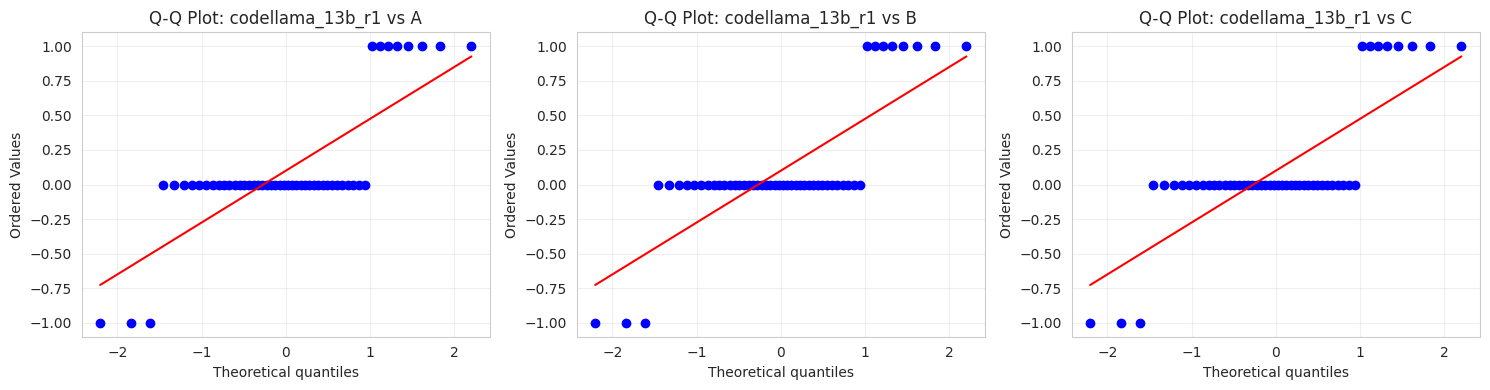


Summary of differences (d = W^h - W^f) for each human:

vs A:
  Mean: 0.1000
  Std: 0.4629
  Min: -1.0, Max: 1.0
  Unique values: 3 (possible: (-1, 0, 1))

vs B:
  Mean: 0.1000
  Std: 0.4629
  Min: -1.0, Max: 1.0
  Unique values: 3 (possible: (-1, 0, 1))

vs C:
  Mean: 0.1000
  Std: 0.4629
  Min: -1.0, Max: 1.0
  Unique values: 3 (possible: (-1, 0, 1))


In [215]:
# Visualize normality of differences for the test case
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (human, res) in enumerate(test_results.items()):
    d = np.array(res['W_h']) - np.array(res['W_f'])
    
    # Q-Q plot
    stats.probplot(d, dist="norm", plot=axes[idx])
    axes[idx].set_title(f'Q-Q Plot: {test_llm} vs {human}')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics for differences
print("\nSummary of differences (d = W^h - W^f) for each human:")
for human, res in test_results.items():
    d = np.array(res['W_h']) - np.array(res['W_f'])
    print(f"\nvs {human}:")
    print(f"  Mean: {np.mean(d):.4f}")
    print(f"  Std: {np.std(d, ddof=1):.4f}")
    print(f"  Min: {np.min(d):.1f}, Max: {np.max(d):.1f}")
    print(f"  Unique values: {len(np.unique(d))} (possible: {-1, 0, 1})")


## 5. Individual Category Analysis <a id="5-individual"></a>

We now perform the complete Alt-Test for each commit category (BFC, BPC, PRC, NFC) individually.

In [216]:
def analyze_llms_for_category(category_df, llm_names, human_annotators, epsilon=0.0, alpha=0.05):
    """
    Perform Alt-Test for all LLMs on a single category.
    
    Returns:
        DataFrame with results for all LLMs
    """
    results = []
    
    for llm_name in llm_names:
        # Compute advantage probabilities
        adv_probs = compute_advantage_probabilities(
            category_df, llm_name, human_annotators
        )
        
        # Perform alt-test
        alt_test = perform_alt_test(adv_probs, epsilon, alpha)
        
        # Store results
        result_row = {
            'LLM': llm_name,
            'Winning_Rate': alt_test['winning_rate'],
            'Avg_Advantage_Prob': alt_test['avg_advantage_prob'],
            'Can_Replace': alt_test['can_replace']
        }
        
        # Add per-human results
        for human in human_annotators:
            res = alt_test['test_results'][human]
            result_row[f'rho_f_vs_{human}'] = res['rho_f']
            result_row[f'p_value_vs_{human}'] = res['p_value']
            result_row[f'rejected_vs_{human}'] = res['rejected']
        
        results.append(result_row)
    
    return pd.DataFrame(results)

In [217]:
# Analyze all categories
category_results = {}
llm_names = list(llm_data.keys())

for category in categories:
    results_df = analyze_llms_for_category(
        unified_data[category],
        llm_names,
        human_annotators,
        epsilon=EPSILON_PRIMARY,
        alpha=ALPHA
    )
    category_results[category] = results_df

In [218]:
# Summary: Statistical test selection across all categories
print("="*80)
print("STATISTICAL TEST SELECTION SUMMARY")
print("="*80)
print("\nChecking normality assumption for all LLM-human comparisons...")
print("(Shapiro-Wilk test: p > 0.05 indicates normal distribution)\n")

for category in categories:
    print(f"\n{category.upper()} Category:")
    
    # Re-run one LLM to get normality info
    test_llm_name = llm_names[0]
    adv_probs = compute_advantage_probabilities(
        unified_data[category], test_llm_name, human_annotators
    )
    alt_test = perform_alt_test(adv_probs, epsilon=EPSILON_PRIMARY, alpha=ALPHA)
    
    parametric_count = 0
    nonparametric_count = 0
    
    for human, res in alt_test['test_results'].items():
        if res['test_used'] == 'paired_t_test':
            parametric_count += 1
        else:
            nonparametric_count += 1
        
        if res['normality_test']:
            norm = res['normality_test']
            test_type = "✓ t-test" if res['test_used'] == 'paired_t_test' else "✗ Wilcoxon"
            print(f"  {test_llm_name} vs {human}: Shapiro p={norm['p_value']:.4f} → {test_type}")
    
    print(f"  Summary: {parametric_count} parametric, {nonparametric_count} non-parametric tests")

print("\n" + "="*80)
print("\nNote: The same test selection logic applies to all LLMs in each category.")
print("If normality holds for one LLM, it typically holds for others with similar")
print("sample sizes, as differences are binary indicators (W^h - W^f ∈ {-1, 0, 1}).")
print("="*80)


STATISTICAL TEST SELECTION SUMMARY

Checking normality assumption for all LLM-human comparisons...
(Shapiro-Wilk test: p > 0.05 indicates normal distribution)


BFC Category:
  codellama_13b_r1 vs A: Shapiro p=0.0000 → ✗ Wilcoxon
  codellama_13b_r1 vs B: Shapiro p=0.0000 → ✗ Wilcoxon
  codellama_13b_r1 vs C: Shapiro p=0.0000 → ✗ Wilcoxon
  Summary: 0 parametric, 3 non-parametric tests

BPC Category:
  codellama_13b_r1 vs A: Shapiro p=0.0000 → ✗ Wilcoxon
  codellama_13b_r1 vs B: Shapiro p=0.0000 → ✗ Wilcoxon
  codellama_13b_r1 vs C: Shapiro p=0.0000 → ✗ Wilcoxon
  Summary: 0 parametric, 3 non-parametric tests

PRC Category:
  codellama_13b_r1 vs A: Shapiro p=0.0000 → ✗ Wilcoxon
  codellama_13b_r1 vs B: Shapiro p=0.0000 → ✗ Wilcoxon
  codellama_13b_r1 vs C: Shapiro p=0.0000 → ✗ Wilcoxon
  Summary: 0 parametric, 3 non-parametric tests

NFC Category:
  codellama_13b_r1 vs A: Shapiro p=0.0000 → ✗ Wilcoxon
  codellama_13b_r1 vs B: Shapiro p=0.0000 → ✗ Wilcoxon
  codellama_13b_r1 vs C: Shapir

In [219]:
# Display results for each category with detailed p-values
for category in categories:
    print(f"\n{'='*100}")
    print(f"{category.upper()} CATEGORY RESULTS")
    print(f"{'='*100}")
    
    df = category_results[category].sort_values('Avg_Advantage_Prob', ascending=False)
    
    # Display summary columns
    display_cols = ['LLM', 'Winning_Rate', 'Avg_Advantage_Prob', 'Can_Replace']
    display(df[display_cols])
    
    # Detailed p-values table
    print(f"\n{'-'*100}")
    print("DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)")
    print(f"{'-'*100}")
    print(f"{'LLM':<30} {'vs A':<20} {'vs B':<20} {'vs C':<20}")
    print(f"{'-'*100}")
    
    for idx, row in df.iterrows():
        p_a = row['p_value_vs_A']
        p_b = row['p_value_vs_B']
        p_c = row['p_value_vs_C']
        
        rej_a = '✓' if row['rejected_vs_A'] else '✗'
        rej_b = '✓' if row['rejected_vs_B'] else '✗'
        rej_c = '✓' if row['rejected_vs_C'] else '✗'
        
        print(f"{row['LLM']:<30} {rej_a} p={p_a:.6f}    {rej_b} p={p_b:.6f}    {rej_c} p={p_c:.6f}")
    
    print(f"{'-'*100}")
    print("Legend: ✓ = H₀ rejected (LLM wins), ✗ = H₀ not rejected")
    
    # Advantage probabilities table
    print(f"\n{'-'*100}")
    print("ADVANTAGE PROBABILITIES (ρ^f): Probability that LLM ≥ Human")
    print(f"{'-'*100}")
    print(f"{'LLM':<30} {'vs A':<15} {'vs B':<15} {'vs C':<15} {'Average':<15}")
    print(f"{'-'*100}")
    
    for idx, row in df.iterrows():
        rho_a = row['rho_f_vs_A']
        rho_b = row['rho_f_vs_B']
        rho_c = row['rho_f_vs_C']
        avg = row['Avg_Advantage_Prob']
        
        print(f"{row['LLM']:<30} {rho_a:.4f}          {rho_b:.4f}          {rho_c:.4f}          {avg:.4f}")
    
    print(f"{'-'*100}")
    
    # Summary statistics
    n_can_replace = df['Can_Replace'].sum()
    print(f"\n📊 SUMMARY: {n_can_replace}/{len(df)} LLMs can replace human annotators (ω ≥ 0.5)")
    print(f"🏆 Best LLM: {df.iloc[0]['LLM']} (ρ = {df.iloc[0]['Avg_Advantage_Prob']:.4f}, ω = {df.iloc[0]['Winning_Rate']:.3f})")
    
    # Show which humans were beaten by best LLM
    best = df.iloc[0]
    beaten = []
    if best['rejected_vs_A']:
        beaten.append('A')
    if best['rejected_vs_B']:
        beaten.append('B')
    if best['rejected_vs_C']:
        beaten.append('C')
    
    if beaten:
        print(f"   Beats humans: {', '.join(beaten)}")
    else:
        print(f"   Does not beat any human (ω < 0.5)")


BFC CATEGORY RESULTS


,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
4,llama3.1_8b_r1,1.0,0.92,True
11,gpt-oss_120b_r2,1.0,0.92,True
10,gemma3_12b_r2,1.0,0.90,True
3,gpt-oss_20b_r1,1.0,0.90,True
12,gpt-oss_20b_r2,1.0,0.88,True
15,qwen3-coder_30b_r2,1.0,0.88,True
6,qwen3-coder_30b_r1,1.0,0.88,True
2,gemma3_12b_r1,1.0,0.88,True
8,deepseek-r1_14b_r2,1.0,0.86,True
9,deepseek-r1_70b_r2,1.0,0.86,True



----------------------------------------------------------------------------------------------------
DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)
----------------------------------------------------------------------------------------------------
LLM                            vs A                 vs B                 vs C                
----------------------------------------------------------------------------------------------------
llama3.1_8b_r1                 ✓ p=0.000001    ✓ p=0.000001    ✓ p=0.000001
gpt-oss_120b_r2                ✓ p=0.000001    ✓ p=0.000001    ✓ p=0.000001
gemma3_12b_r2                  ✓ p=0.000012    ✓ p=0.000008    ✓ p=0.000011
gpt-oss_20b_r1                 ✓ p=0.000009    ✓ p=0.000008    ✓ p=0.000011
gpt-oss_20b_r2                 ✓ p=0.000084    ✓ p=0.000071    ✓ p=0.000071
qwen3-coder_30b_r2             ✓ p=0.000098    ✓ p=0.000061    ✓ p=0.000071
qwen3-coder_30b_r1             ✓ p=0.000084    ✓ p=0.000051    ✓ p=0

,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
8,deepseek-r1_14b_r2,1.0,0.820000,True
11,gpt-oss_120b_r2,0.0,0.760000,False
12,gpt-oss_20b_r2,0.0,0.706667,False
1,deepseek-r1_14b_r1,0.0,0.660000,False
10,gemma3_12b_r2,0.0,0.613333,False
14,mistral_7b_r2,0.0,0.606667,False
7,codellama_13b_r2,0.0,0.600000,False
3,gpt-oss_20b_r1,0.0,0.586667,False
15,qwen3-coder_30b_r2,0.0,0.580000,False
6,qwen3-coder_30b_r1,0.0,0.573333,False



----------------------------------------------------------------------------------------------------
DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)
----------------------------------------------------------------------------------------------------
LLM                            vs A                 vs B                 vs C                
----------------------------------------------------------------------------------------------------
deepseek-r1_14b_r2             ✓ p=0.003262    ✓ p=0.000894    ✓ p=0.003262
gpt-oss_120b_r2                ✗ p=0.023693    ✗ p=0.010032    ✗ p=0.030838
gpt-oss_20b_r2                 ✗ p=0.131577    ✗ p=0.104290    ✗ p=0.250870
deepseek-r1_14b_r1             ✗ p=0.278787    ✗ p=0.094889    ✗ p=0.367027
gemma3_12b_r2                  ✗ p=0.111408    ✗ p=0.150705    ✗ p=0.195643
mistral_7b_r2                  ✗ p=0.316987    ✗ p=0.393602    ✗ p=0.548934
codellama_13b_r2               ✗ p=0.625574    ✗ p=0.548934    ✗ p=0

,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
3,gpt-oss_20b_r1,1.0,0.846667,True
11,gpt-oss_120b_r2,1.0,0.800000,True
8,deepseek-r1_14b_r2,0.0,0.726667,False
12,gpt-oss_20b_r2,0.0,0.680000,False
1,deepseek-r1_14b_r1,0.0,0.626667,False
15,qwen3-coder_30b_r2,0.0,0.580000,False
6,qwen3-coder_30b_r1,0.0,0.540000,False
9,deepseek-r1_70b_r2,0.0,0.500000,False
0,codellama_13b_r1,0.0,0.460000,False
2,gemma3_12b_r1,0.0,0.440000,False



----------------------------------------------------------------------------------------------------
DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)
----------------------------------------------------------------------------------------------------
LLM                            vs A                 vs B                 vs C                
----------------------------------------------------------------------------------------------------
gpt-oss_20b_r1                 ✓ p=0.001183    ✓ p=0.000224    ✓ p=0.001477
gpt-oss_120b_r2                ✓ p=0.009469    ✓ p=0.002500    ✓ p=0.012075
deepseek-r1_14b_r2             ✗ p=0.131577    ✗ p=0.059862    ✗ p=0.162938
gpt-oss_20b_r2                 ✗ p=0.478097    ✗ p=0.415230    ✗ p=0.605018
deepseek-r1_14b_r1             ✗ p=0.799405    ✗ p=0.367027    ✗ p=0.741911
qwen3-coder_30b_r2             ✗ p=0.632827    ✗ p=0.470652    ✗ p=0.632827
qwen3-coder_30b_r1             ✗ p=0.834055    ✗ p=0.525452    ✗ p=0

,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
11,gpt-oss_120b_r2,1.0,1.000000,True
4,llama3.1_8b_r1,1.0,0.980000,True
9,deepseek-r1_70b_r2,1.0,0.980000,True
1,deepseek-r1_14b_r1,1.0,0.960000,True
15,qwen3-coder_30b_r2,1.0,0.960000,True
8,deepseek-r1_14b_r2,1.0,0.960000,True
2,gemma3_12b_r1,1.0,0.906667,True
3,gpt-oss_20b_r1,1.0,0.900000,True
13,llama3.1_8b_r2,1.0,0.900000,True
12,gpt-oss_20b_r2,1.0,0.900000,True



----------------------------------------------------------------------------------------------------
DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)
----------------------------------------------------------------------------------------------------
LLM                            vs A                 vs B                 vs C                
----------------------------------------------------------------------------------------------------
gpt-oss_120b_r2                ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
llama3.1_8b_r1                 ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
deepseek-r1_70b_r2             ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
deepseek-r1_14b_r1             ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
qwen3-coder_30b_r2             ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
deepseek-r1_14b_r2             ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
gemma3_12b_r1                  ✓ p=0.000009    ✓ p=0.000001    ✓ p=0

## 6. Combined Category Analysis <a id="6-combined"></a>

We now analyze all four categories together, treating the annotation as a 4-dimensional vector.
We use RMSE across all dimensions simultaneously.

In [220]:
def compute_multivariate_rmse_score(f_annotations, other_annotations):
    """
    Compute negative RMSE for multivariate annotations (all 4 categories).
    
    Args:
        f_annotations: 1D array with 4 values [bfc, bpc, prc, nfc]
        other_annotations: 2D array (n_annotators × 4)
    
    Returns:
        Negative RMSE score
    """
    # Compute squared differences across all dimensions
    squared_diffs = np.sum((f_annotations - other_annotations) ** 2, axis=1)
    return -np.sqrt(np.mean(squared_diffs))

def compute_combined_advantage_probabilities(unified_data, llm_name, human_annotators, categories):
    """
    Compute advantage probabilities considering all categories together.
    """
    # Create combined dataset with all categories
    # We need commits that have complete annotations across all categories
    combined_df = unified_data[categories[0]][['hash']].copy()
    
    for cat in categories:
        cat_df = unified_data[cat]
        # Add columns with category suffix
        for col in human_annotators + [llm_name]:
            combined_df = combined_df.merge(
                cat_df[['hash', col]].rename(columns={col: f'{col}_{cat}'}),
                on='hash',
                how='inner'
            )
    
    results = {}
    
    for excluded_human in human_annotators:
        remaining_humans = [h for h in human_annotators if h != excluded_human]
        
        W_f_list = []
        W_h_list = []
        
        for idx, row in combined_df.iterrows():
            # Get multivariate annotations (4D vectors)
            llm_annotation = np.array([row[f'{llm_name}_{cat}'] for cat in categories])
            excluded_annotation = np.array([row[f'{excluded_human}_{cat}'] for cat in categories])
            remaining_annotations = np.array([
                [row[f'{h}_{cat}'] for cat in categories]
                for h in remaining_humans
            ])
            
            # Compute scores
            S_llm = compute_multivariate_rmse_score(llm_annotation, remaining_annotations)
            S_human = compute_multivariate_rmse_score(excluded_annotation, remaining_annotations)
            
            # Indicators
            W_f = 1 if S_llm >= S_human else 0
            W_h = 1 if S_human >= S_llm else 0
            
            W_f_list.append(W_f)
            W_h_list.append(W_h)
        
        results[excluded_human] = {
            'rho_f': np.mean(W_f_list),
            'rho_h': np.mean(W_h_list),
            'W_f': W_f_list,
            'W_h': W_h_list,
            'n_instances': len(W_f_list)
        }
    
    return results

In [221]:
# Perform combined analysis for all LLMs
print(f"Performing combined category analysis (ε={EPSILON_PRIMARY})...\n")
combined_results = []

for llm_name in llm_names:
    print(f"  Analyzing {llm_name}...")
    
    # Compute advantage probabilities
    adv_probs = compute_combined_advantage_probabilities(
        unified_data, llm_name, human_annotators, categories
    )
    
    # Perform alt-test
    alt_test = perform_alt_test(adv_probs, epsilon=EPSILON_PRIMARY, alpha=ALPHA)
    
    # Store results
    result_row = {
        'LLM': llm_name,
        'Winning_Rate': alt_test['winning_rate'],
        'Avg_Advantage_Prob': alt_test['avg_advantage_prob'],
        'Can_Replace': alt_test['can_replace']
    }
    
    for human in human_annotators:
        res = alt_test['test_results'][human]
        result_row[f'rho_f_vs_{human}'] = res['rho_f']
        result_row[f'p_value_vs_{human}'] = res['p_value']
        result_row[f'rejected_vs_{human}'] = res['rejected']
    
    combined_results.append(result_row)

combined_results_df = pd.DataFrame(combined_results).sort_values('Avg_Advantage_Prob', ascending=False)

Performing combined category analysis (ε=0.05)...

  Analyzing codellama_13b_r1...
  Analyzing deepseek-r1_14b_r1...
  Analyzing deepseek-r1_14b_r1...
  Analyzing gemma3_12b_r1...
  Analyzing gemma3_12b_r1...
  Analyzing gpt-oss_20b_r1...
  Analyzing gpt-oss_20b_r1...
  Analyzing llama3.1_8b_r1...
  Analyzing llama3.1_8b_r1...
  Analyzing mistral_7b_r1...
  Analyzing mistral_7b_r1...
  Analyzing qwen3-coder_30b_r1...
  Analyzing qwen3-coder_30b_r1...
  Analyzing codellama_13b_r2...
  Analyzing deepseek-r1_14b_r2...
  Analyzing codellama_13b_r2...
  Analyzing deepseek-r1_14b_r2...
  Analyzing deepseek-r1_70b_r2...
  Analyzing deepseek-r1_70b_r2...
  Analyzing gemma3_12b_r2...
  Analyzing gpt-oss_120b_r2...
  Analyzing gpt-oss_20b_r2...
  Analyzing gemma3_12b_r2...
  Analyzing gpt-oss_120b_r2...
  Analyzing gpt-oss_20b_r2...
  Analyzing llama3.1_8b_r2...
  Analyzing mistral_7b_r2...
  Analyzing qwen3-coder_30b_r2...
  Analyzing llama3.1_8b_r2...
  Analyzing mistral_7b_r2...
  Analyzing q

In [222]:
# Display combined results with detailed information
print("\n" + "="*100)
print("COMBINED CATEGORY RESULTS (All 4 categories together)")
print("="*100 + "\n")

display_cols = ['LLM', 'Winning_Rate', 'Avg_Advantage_Prob', 'Can_Replace']
display(combined_results_df[display_cols])

# Detailed p-values table
print(f"\n{'-'*100}")
print("DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)")
print(f"{'-'*100}")
print(f"{'LLM':<30} {'vs A':<20} {'vs B':<20} {'vs C':<20}")
print(f"{'-'*100}")

for idx, row in combined_results_df.iterrows():
    p_a = row['p_value_vs_A']
    p_b = row['p_value_vs_B']
    p_c = row['p_value_vs_C']
    
    rej_a = '✓' if row['rejected_vs_A'] else '✗'
    rej_b = '✓' if row['rejected_vs_B'] else '✗'
    rej_c = '✓' if row['rejected_vs_C'] else '✗'
    
    print(f"{row['LLM']:<30} {rej_a} p={p_a:.6f}    {rej_b} p={p_b:.6f}    {rej_c} p={p_c:.6f}")

print(f"{'-'*100}")
print("Legend: ✓ = H₀ rejected (LLM wins), ✗ = H₀ not rejected")

# Advantage probabilities table
print(f"\n{'-'*100}")
print("ADVANTAGE PROBABILITIES (ρ^f): Probability that LLM ≥ Human")
print(f"{'-'*100}")
print(f"{'LLM':<30} {'vs A':<15} {'vs B':<15} {'vs C':<15} {'Average':<15}")
print(f"{'-'*100}")

for idx, row in combined_results_df.iterrows():
    rho_a = row['rho_f_vs_A']
    rho_b = row['rho_f_vs_B']
    rho_c = row['rho_f_vs_C']
    avg = row['Avg_Advantage_Prob']
    
    print(f"{row['LLM']:<30} {rho_a:.4f}          {rho_b:.4f}          {rho_c:.4f}          {avg:.4f}")

print(f"{'-'*100}")

n_can_replace = combined_results_df['Can_Replace'].sum()
print(f"\n📊 SUMMARY: {n_can_replace}/{len(combined_results_df)} LLMs can replace human annotators (ω ≥ 0.5)")
print(f"🏆 Best LLM: {combined_results_df.iloc[0]['LLM']} (ρ = {combined_results_df.iloc[0]['Avg_Advantage_Prob']:.4f}, ω = {combined_results_df.iloc[0]['Winning_Rate']:.3f})")

# Show which humans were beaten by best LLM
best = combined_results_df.iloc[0]
beaten = []
if best['rejected_vs_A']:
    beaten.append('A')
if best['rejected_vs_B']:
    beaten.append('B')
if best['rejected_vs_C']:
    beaten.append('C')

if beaten:
    print(f"   Beats humans: {', '.join(beaten)}")
else:
    print(f"   Does not beat any human (ω < 0.5)")

# Statistical significance summary
print(f"\n{'-'*100}")
print("STATISTICAL SIGNIFICANCE SUMMARY")
print(f"{'-'*100}")
print(f"Epsilon (ε):             {EPSILON_PRIMARY}")
print(f"Significance level (α):  {ALPHA}")
print(f"Multiple testing:        Benjamini-Yekutieli FDR correction")
print(f"Statistical test:        Wilcoxon signed-rank (non-parametric, for non-normal differences)")
print(f"\nInterpretation of results:")
print(f"  - ✓ (rejected): p < {ALPHA} after BY correction → LLM significantly better than human")
print(f"  - ✗ (not rejected): p ≥ {ALPHA} → Insufficient evidence that LLM is better")
print(f"  - Winning Rate (ω): Proportion of humans beaten (need ω ≥ 0.5 to replace)")
print(f"{'-'*100}")


COMBINED CATEGORY RESULTS (All 4 categories together)



,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
11,gpt-oss_120b_r2,0.0,0.646667,False
8,deepseek-r1_14b_r2,0.0,0.540000,False
3,gpt-oss_20b_r1,0.0,0.486667,False
12,gpt-oss_20b_r2,0.0,0.480000,False
6,qwen3-coder_30b_r1,0.0,0.440000,False
1,deepseek-r1_14b_r1,0.0,0.406667,False
9,deepseek-r1_70b_r2,0.0,0.386667,False
15,qwen3-coder_30b_r2,0.0,0.386667,False
2,gemma3_12b_r1,0.0,0.320000,False
10,gemma3_12b_r2,0.0,0.306667,False



----------------------------------------------------------------------------------------------------
DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)
----------------------------------------------------------------------------------------------------
LLM                            vs A                 vs B                 vs C                
----------------------------------------------------------------------------------------------------
gpt-oss_120b_r2                ✗ p=0.179099    ✗ p=0.056897    ✗ p=0.606997
deepseek-r1_14b_r2             ✗ p=0.884592    ✗ p=0.389893    ✗ p=0.968068
gpt-oss_20b_r1                 ✗ p=0.756083    ✗ p=0.846320    ✗ p=0.975801
gpt-oss_20b_r2                 ✗ p=0.920127    ✗ p=0.805629    ✗ p=0.999741
qwen3-coder_30b_r1             ✗ p=0.498034    ✗ p=0.470412    ✗ p=0.968808
deepseek-r1_14b_r1             ✗ p=0.958234    ✗ p=0.580370    ✗ p=0.996963
deepseek-r1_70b_r2             ✗ p=0.470412    ✗ p=0.795207    ✗ p=0

## 7. Visualizations <a id="7-visualizations"></a>

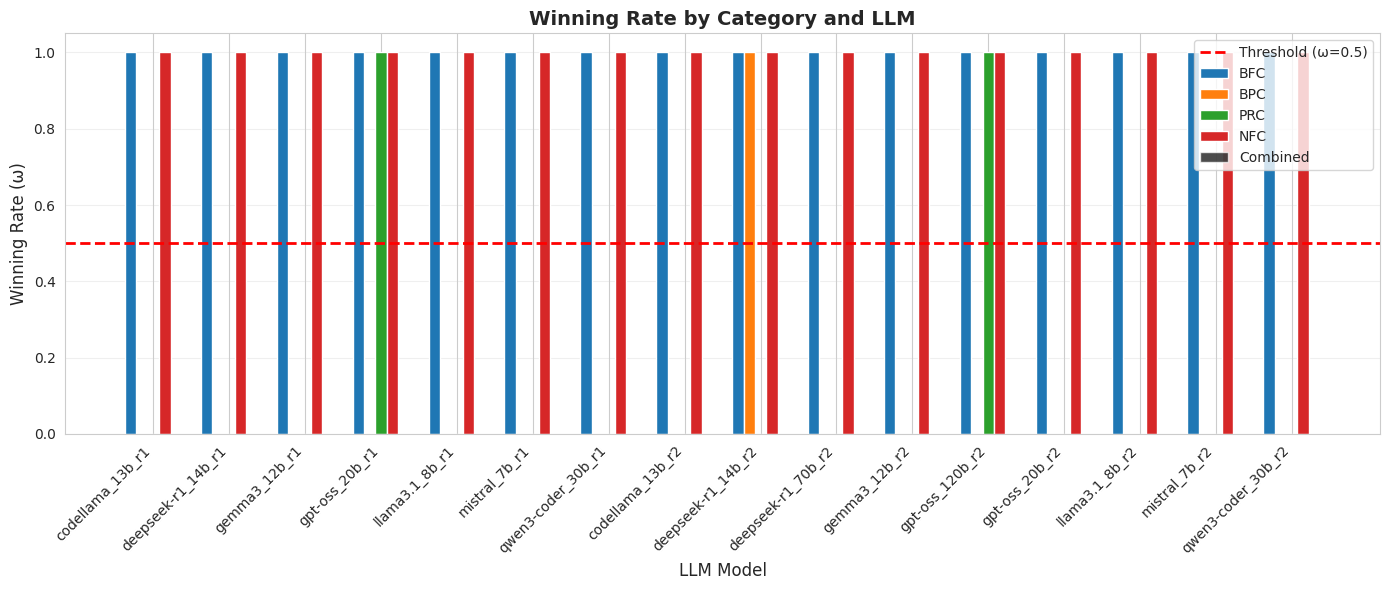

In [223]:
# 1. Winning Rate comparison across categories
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(llm_names))
width = 0.15

for i, category in enumerate(categories):
    df = category_results[category].set_index('LLM').loc[llm_names]
    ax.bar(x + i*width, df['Winning_Rate'], width, label=category.upper())

# Add combined results
combined_df = combined_results_df.set_index('LLM').loc[llm_names]
ax.bar(x + 4*width, combined_df['Winning_Rate'], width, label='Combined', color='black', alpha=0.7)

ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (ω=0.5)')
ax.set_xlabel('LLM Model', fontsize=12)
ax.set_ylabel('Winning Rate (ω)', fontsize=12)
ax.set_title('Winning Rate by Category and LLM', fontsize=14, fontweight='bold')
ax.set_xticks(x + 2*width)
ax.set_xticklabels(llm_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

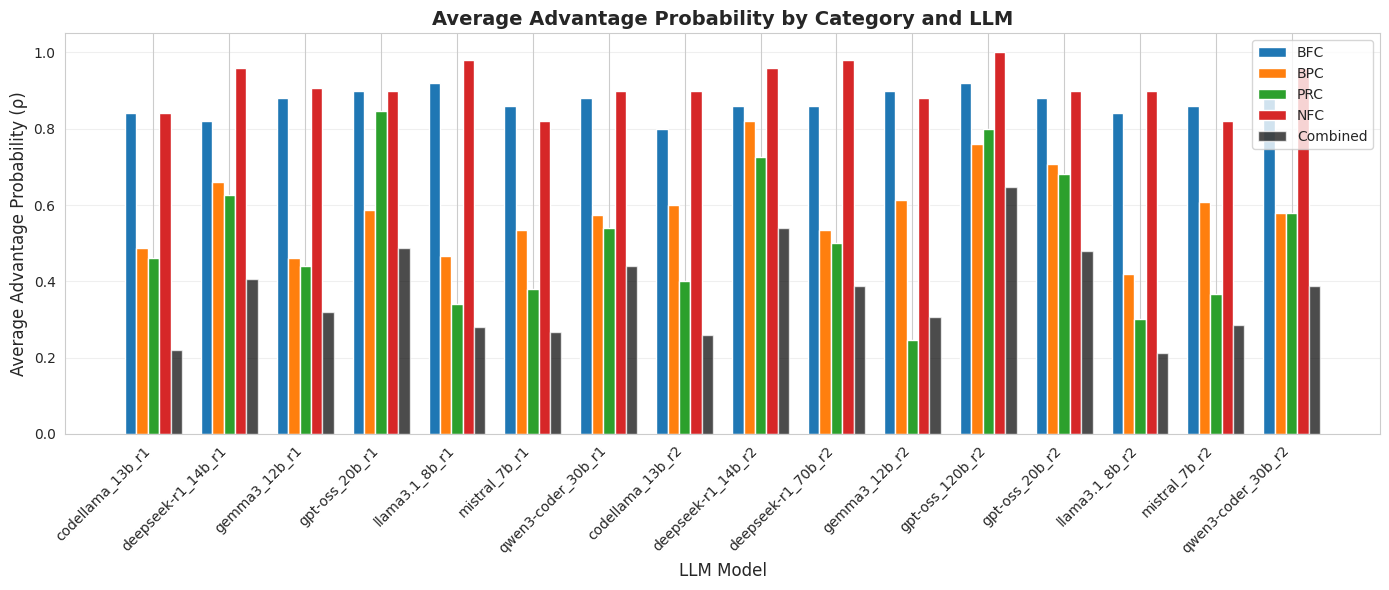

In [224]:
# 2. Average Advantage Probability (ρ) comparison
fig, ax = plt.subplots(figsize=(14, 6))

for i, category in enumerate(categories):
    df = category_results[category].set_index('LLM').loc[llm_names]
    ax.bar(x + i*width, df['Avg_Advantage_Prob'], width, label=category.upper())

combined_df = combined_results_df.set_index('LLM').loc[llm_names]
ax.bar(x + 4*width, combined_df['Avg_Advantage_Prob'], width, label='Combined', color='black', alpha=0.7)

ax.set_xlabel('LLM Model', fontsize=12)
ax.set_ylabel('Average Advantage Probability (ρ)', fontsize=12)
ax.set_title('Average Advantage Probability by Category and LLM', fontsize=14, fontweight='bold')
ax.set_xticks(x + 2*width)
ax.set_xticklabels(llm_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

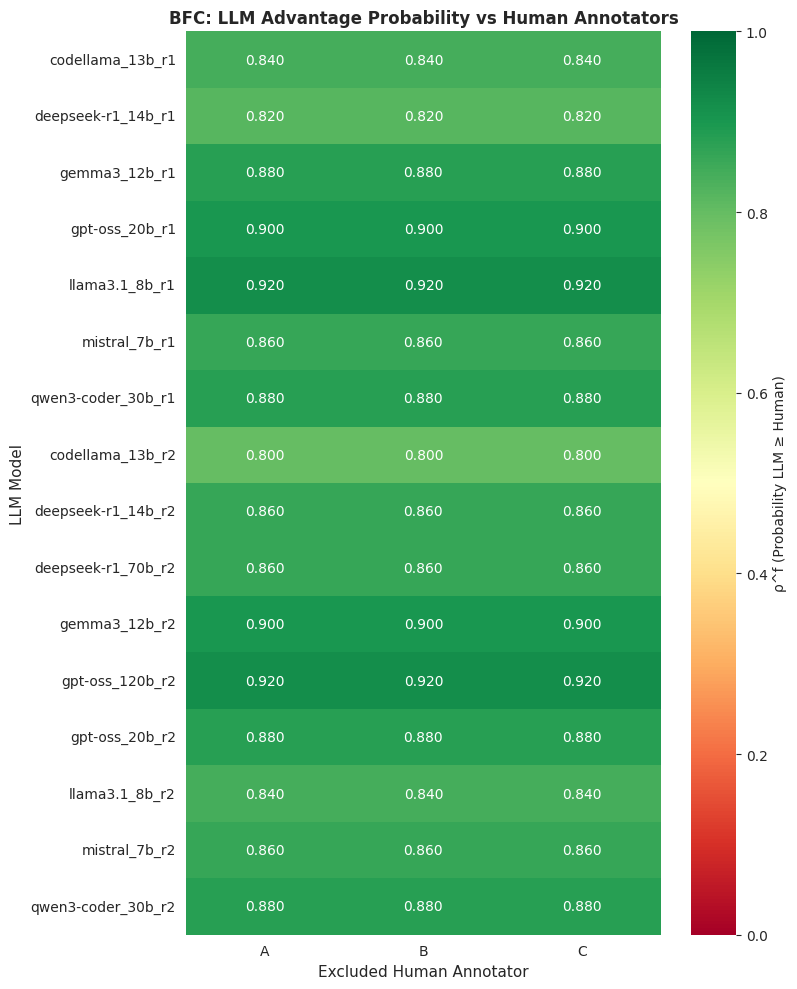

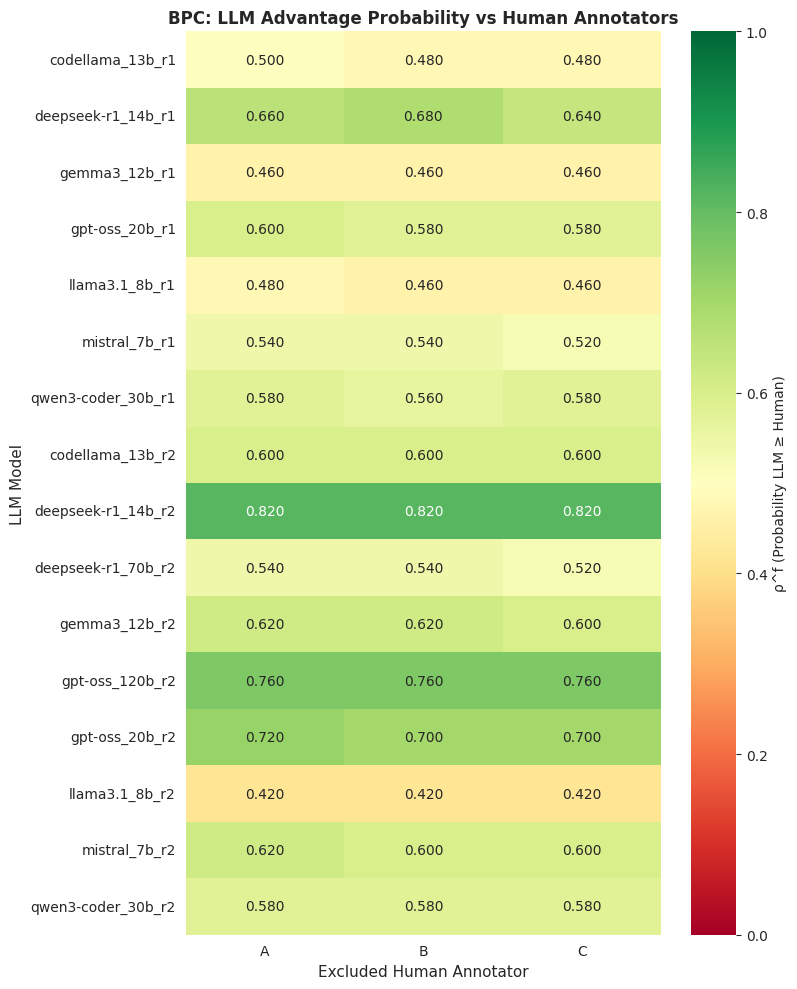

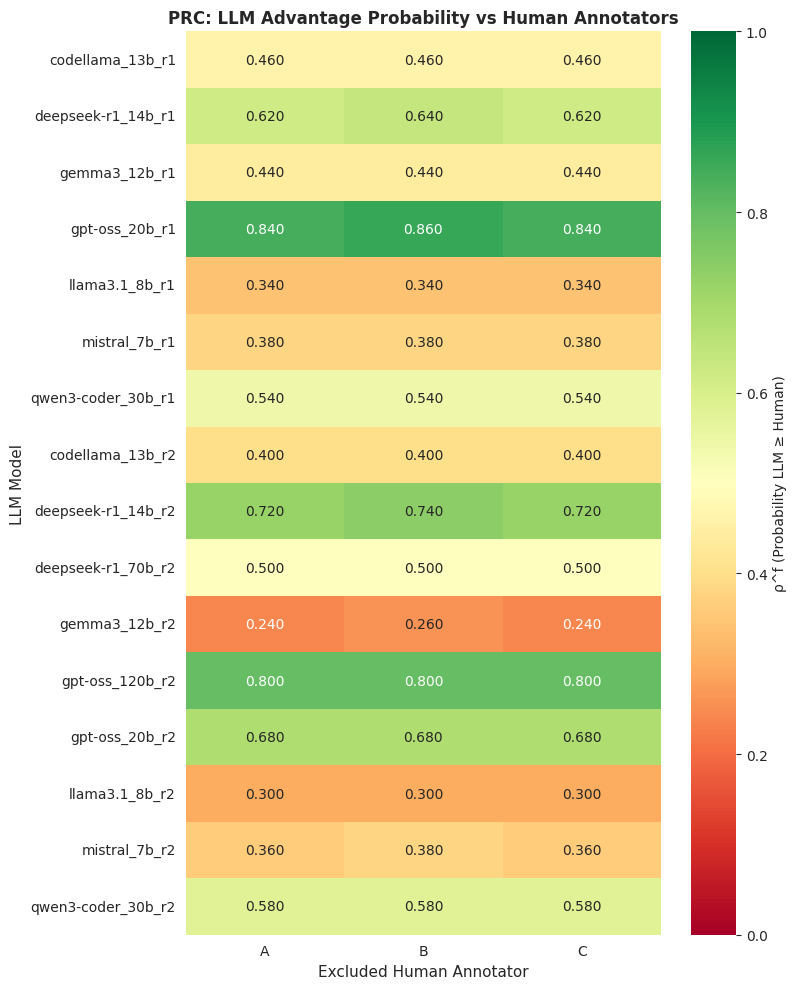

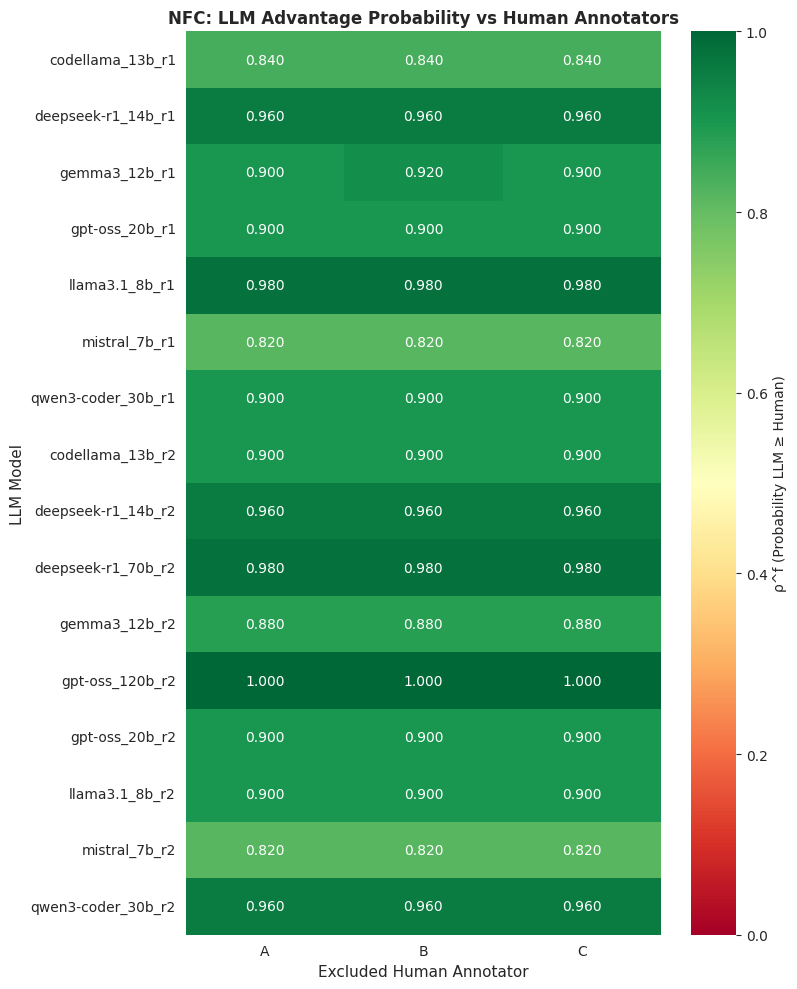

In [225]:
# 3. Heatmap of ρ^f (LLM advantage probability) vs human annotators
for category in categories:
    fig, ax = plt.subplots(figsize=(8, 10))
    
    df = category_results[category]
    
    # Create matrix: rows=LLMs, cols=human annotators
    matrix = np.zeros((len(llm_names), len(human_annotators)))
    for i, llm in enumerate(llm_names):
        for j, human in enumerate(human_annotators):
            matrix[i, j] = df[df['LLM'] == llm][f'rho_f_vs_{human}'].values[0]
    
    sns.heatmap(matrix, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
                xticklabels=human_annotators, yticklabels=llm_names,
                cbar_kws={'label': 'ρ^f (Probability LLM ≥ Human)'}, ax=ax)
    
    ax.set_title(f'{category.upper()}: LLM Advantage Probability vs Human Annotators', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Excluded Human Annotator', fontsize=11)
    ax.set_ylabel('LLM Model', fontsize=11)
    plt.tight_layout()
    plt.show()

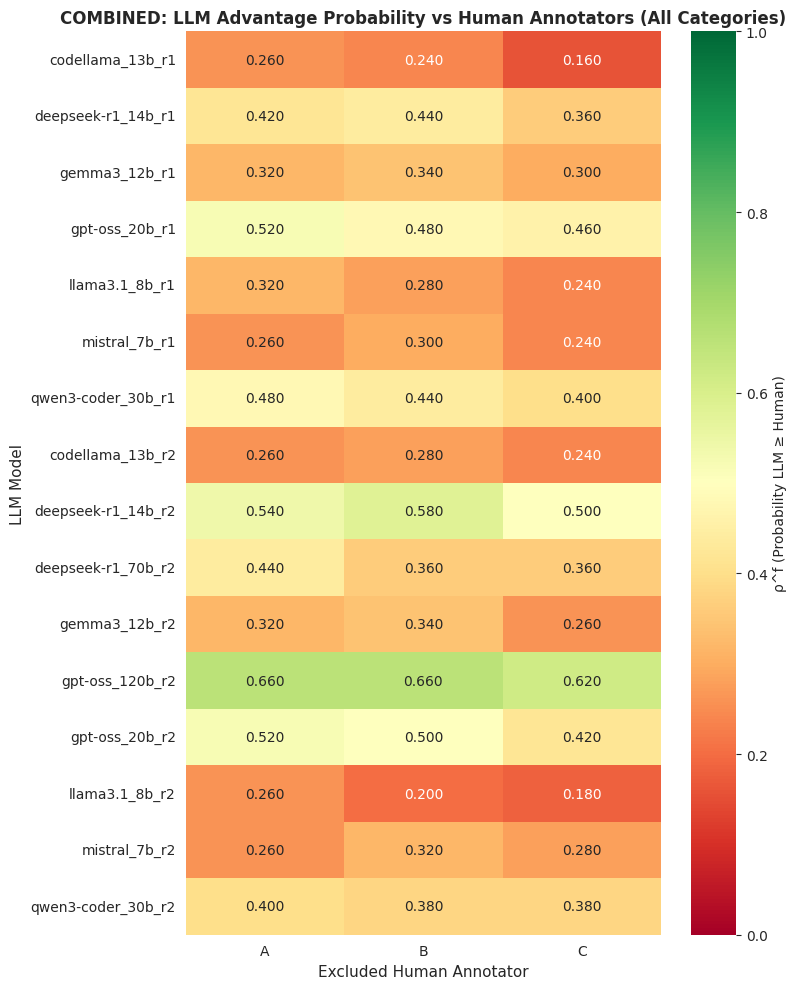

In [226]:
# 4. Combined category heatmap
fig, ax = plt.subplots(figsize=(8, 10))

matrix = np.zeros((len(llm_names), len(human_annotators)))
for i, llm in enumerate(llm_names):
    for j, human in enumerate(human_annotators):
        matrix[i, j] = combined_results_df[combined_results_df['LLM'] == llm][f'rho_f_vs_{human}'].values[0]

sns.heatmap(matrix, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
            xticklabels=human_annotators, yticklabels=llm_names,
            cbar_kws={'label': 'ρ^f (Probability LLM ≥ Human)'}, ax=ax)

ax.set_title('COMBINED: LLM Advantage Probability vs Human Annotators (All Categories)', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('Excluded Human Annotator', fontsize=11)
ax.set_ylabel('LLM Model', fontsize=11)
plt.tight_layout()
plt.show()

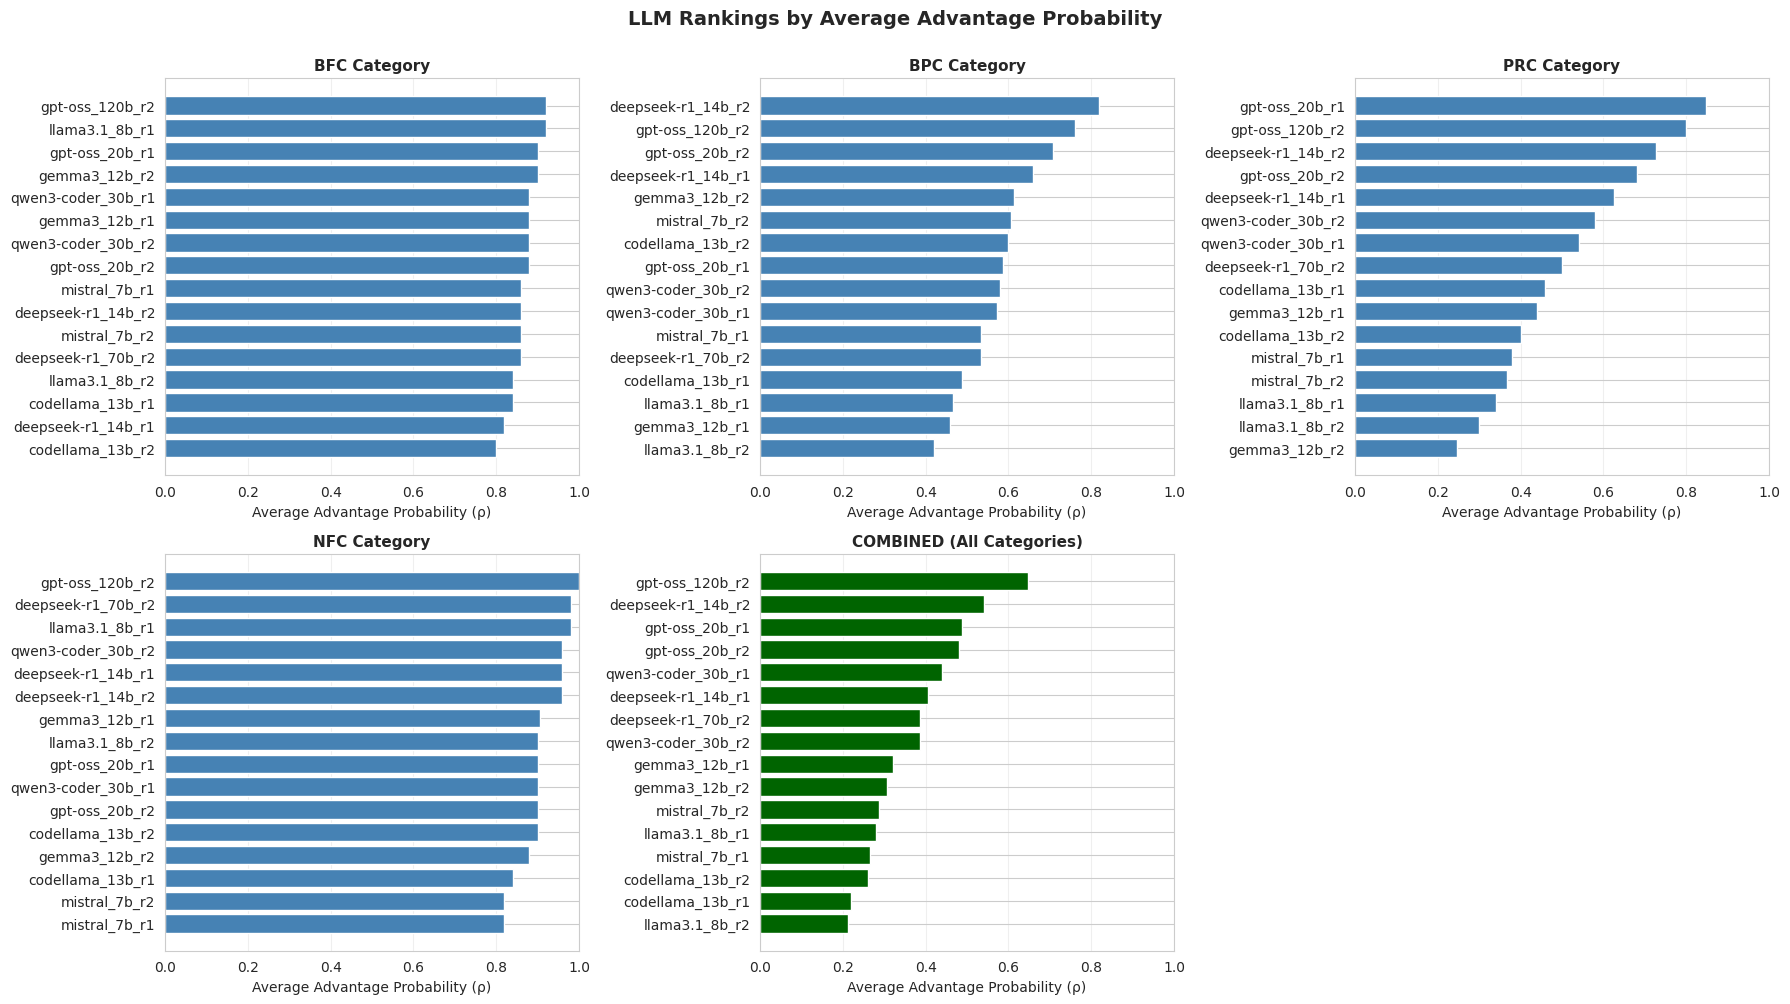

In [227]:
# 5. LLM Ranking by Average Advantage Probability
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Individual categories
for i, category in enumerate(categories):
    df = category_results[category].sort_values('Avg_Advantage_Prob', ascending=True)
    axes[i].barh(df['LLM'], df['Avg_Advantage_Prob'], color='steelblue')
    axes[i].set_xlabel('Average Advantage Probability (ρ)', fontsize=10)
    axes[i].set_title(f'{category.upper()} Category', fontsize=11, fontweight='bold')
    axes[i].grid(axis='x', alpha=0.3)
    axes[i].set_xlim([0, 1])

# Combined
df_combined = combined_results_df.sort_values('Avg_Advantage_Prob', ascending=True)
axes[4].barh(df_combined['LLM'], df_combined['Avg_Advantage_Prob'], color='darkgreen')
axes[4].set_xlabel('Average Advantage Probability (ρ)', fontsize=10)
axes[4].set_title('COMBINED (All Categories)', fontsize=11, fontweight='bold')
axes[4].grid(axis='x', alpha=0.3)
axes[4].set_xlim([0, 1])

# Hide the last subplot
axes[5].axis('off')

plt.suptitle('LLM Rankings by Average Advantage Probability', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 8. Epsilon Sensitivity Analysis <a id="8-sensitivity"></a>

We now test how the results change with different epsilon values to validate our choice of ε=0.15.

In [228]:
# Perform sensitivity analysis with different epsilon values
print("Performing epsilon sensitivity analysis...\n")

sensitivity_results = []

for eps in EPSILON_SENSITIVITY:
    print(f"Testing ε = {eps}")
    
    # Test on combined categories
    for llm_name in llm_names:
        adv_probs = compute_combined_advantage_probabilities(
            unified_data, llm_name, human_annotators, categories
        )
        alt_test = perform_alt_test(adv_probs, epsilon=eps, alpha=ALPHA)
        
        sensitivity_results.append({
            'epsilon': eps,
            'LLM': llm_name,
            'Winning_Rate': alt_test['winning_rate'],
            'Avg_Advantage_Prob': alt_test['avg_advantage_prob'],
            'Can_Replace': alt_test['can_replace']
        })
    
    print(f"  ε={eps}: {sum(r['Can_Replace'] for r in sensitivity_results if r['epsilon']==eps)}/{len(llm_names)} LLMs can replace")

sensitivity_df = pd.DataFrame(sensitivity_results)

Performing epsilon sensitivity analysis...

Testing ε = 0.1
  ε=0.1: 0/16 LLMs can replace
Testing ε = 0.15
  ε=0.1: 0/16 LLMs can replace
Testing ε = 0.15
  ε=0.15: 0/16 LLMs can replace
Testing ε = 0.2
  ε=0.15: 0/16 LLMs can replace
Testing ε = 0.2
  ε=0.2: 0/16 LLMs can replace
  ε=0.2: 0/16 LLMs can replace


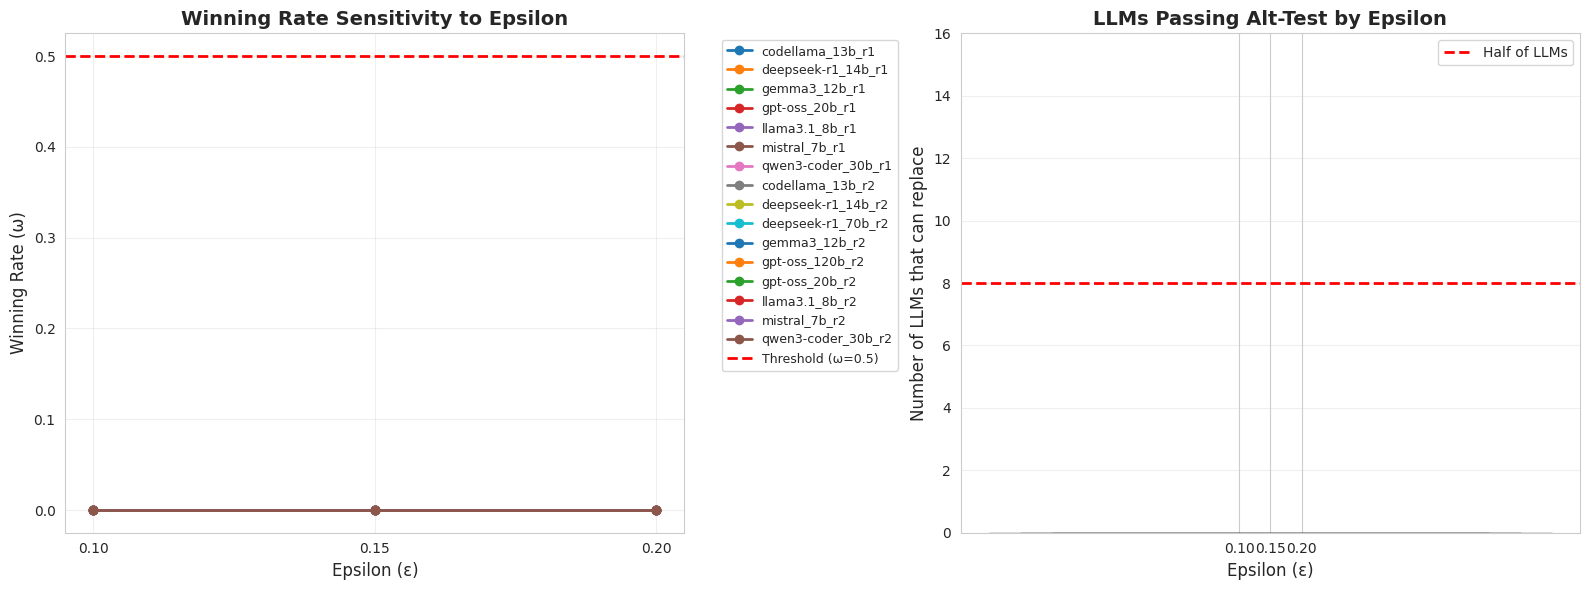

In [229]:
# Visualize sensitivity analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Winning Rate by epsilon
for llm in llm_names:
    llm_data_sens = sensitivity_df[sensitivity_df['LLM'] == llm]
    axes[0].plot(llm_data_sens['epsilon'], llm_data_sens['Winning_Rate'], 
                 marker='o', label=llm, linewidth=2)

axes[0].axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (ω=0.5)')
axes[0].set_xlabel('Epsilon (ε)', fontsize=12)
axes[0].set_ylabel('Winning Rate (ω)', fontsize=12)
axes[0].set_title('Winning Rate Sensitivity to Epsilon', fontsize=14, fontweight='bold')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(alpha=0.3)
axes[0].set_xticks(EPSILON_SENSITIVITY)

# Plot 2: Number of LLMs that can replace by epsilon
can_replace_counts = sensitivity_df.groupby('epsilon')['Can_Replace'].sum()
axes[1].bar(EPSILON_SENSITIVITY, can_replace_counts, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axhline(y=len(llm_names)/2, color='red', linestyle='--', linewidth=2, label='Half of LLMs')
axes[1].set_xlabel('Epsilon (ε)', fontsize=12)
axes[1].set_ylabel('Number of LLMs that can replace', fontsize=12)
axes[1].set_title('LLMs Passing Alt-Test by Epsilon', fontsize=14, fontweight='bold')
axes[1].set_xticks(EPSILON_SENSITIVITY)
axes[1].set_ylim([0, len(llm_names)])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [230]:
# Display sensitivity results table
print("\n" + "="*80)
print("EPSILON SENSITIVITY ANALYSIS RESULTS")
print("="*80)

for eps in EPSILON_SENSITIVITY:
    print(f"\n{'─'*80}")
    print(f"ε = {eps}")
    print(f"{'─'*80}")
    
    eps_results = sensitivity_df[sensitivity_df['epsilon'] == eps].sort_values('Avg_Advantage_Prob', ascending=False)
    
    for idx, row in eps_results.iterrows():
        status = "✓ CAN" if row['Can_Replace'] else "✗ CANNOT"
        print(f"{status:12s} | {row['LLM']:25s} | ω={row['Winning_Rate']:.3f} | ρ={row['Avg_Advantage_Prob']:.3f}")
    
    n_pass = eps_results['Can_Replace'].sum()
    print(f"\nSummary: {n_pass}/{len(llm_names)} LLMs can replace humans with ε={eps}")

print("\n" + "="*80)


EPSILON SENSITIVITY ANALYSIS RESULTS

────────────────────────────────────────────────────────────────────────────────
ε = 0.1
────────────────────────────────────────────────────────────────────────────────
✗ CANNOT     | gpt-oss_120b_r2           | ω=0.000 | ρ=0.647
✗ CANNOT     | deepseek-r1_14b_r2        | ω=0.000 | ρ=0.540
✗ CANNOT     | gpt-oss_20b_r1            | ω=0.000 | ρ=0.487
✗ CANNOT     | gpt-oss_20b_r2            | ω=0.000 | ρ=0.480
✗ CANNOT     | qwen3-coder_30b_r1        | ω=0.000 | ρ=0.440
✗ CANNOT     | deepseek-r1_14b_r1        | ω=0.000 | ρ=0.407
✗ CANNOT     | deepseek-r1_70b_r2        | ω=0.000 | ρ=0.387
✗ CANNOT     | qwen3-coder_30b_r2        | ω=0.000 | ρ=0.387
✗ CANNOT     | gemma3_12b_r1             | ω=0.000 | ρ=0.320
✗ CANNOT     | gemma3_12b_r2             | ω=0.000 | ρ=0.307
✗ CANNOT     | mistral_7b_r2             | ω=0.000 | ρ=0.287
✗ CANNOT     | llama3.1_8b_r1            | ω=0.000 | ρ=0.280
✗ CANNOT     | mistral_7b_r1             | ω=0.000 | ρ=0.26

## 9. Conclusions and Interpretation <a id="9-conclusions"></a>

In [231]:
# Generate comprehensive summary
print("="*80)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*80)
print(f"\n**Epsilon (ε) Used: {EPSILON_PRIMARY}** (skilled annotators)")
print(f"Significance Level (α): {ALPHA}")

print("\n1. OVERALL RESULTS (Combined Categories)")
print("-" * 80)
for idx, row in combined_results_df.iterrows():
    status = "✓ CAN REPLACE" if row['Can_Replace'] else "✗ CANNOT REPLACE"
    print(f"{status:20s} | {row['LLM']:25s} | ω={row['Winning_Rate']:.3f} | ρ={row['Avg_Advantage_Prob']:.3f}")

print("\n2. CATEGORY-SPECIFIC RESULTS")
print("-" * 80)
for category in categories:
    print(f"\n{category.upper()} Category:")
    df = category_results[category]
    can_replace = df[df['Can_Replace'] == True]
    print(f"  {len(can_replace)}/{len(df)} LLMs can replace humans")
    if len(can_replace) > 0:
        best = can_replace.sort_values('Avg_Advantage_Prob', ascending=False).iloc[0]
        print(f"  Best: {best['LLM']} (ρ={best['Avg_Advantage_Prob']:.3f})")

print("\n3. BEST PERFORMING LLMs (by Average Advantage Probability)")
print("-" * 80)
top_3 = combined_results_df.head(3)
for rank, (idx, row) in enumerate(top_3.iterrows(), 1):
    print(f"  #{rank}. {row['LLM']:30s} ρ={row['Avg_Advantage_Prob']:.3f}")

print("\n4. INTERPRETATION")
print("-" * 80)
n_can_replace = combined_results_df['Can_Replace'].sum()
if n_can_replace > 0:
    print(f"✓ {n_can_replace} LLM(s) achieved winning rate ω ≥ 0.5 with ε={EPSILON_PRIMARY}")
    print("  These models can statistically justify replacing a human annotator.")
    print("\n  Winning Rate (ω) interpretation:")
    print("  - ω = proportion of human annotators that the LLM 'beats' in the alt-test")
    print("  - ω ≥ 0.5 means the LLM wins against at least half of the humans")
    print("\n  Average Advantage Probability (ρ) interpretation:")
    print("  - ρ = probability that LLM annotations are ≥ quality of a random human")
    print("  - Higher ρ indicates better overall alignment with human consensus")
else:
    print(f"✗ No LLMs achieved winning rate ω ≥ 0.5 with ε={EPSILON_PRIMARY}")
    print("  None of the tested models can fully replace a human annotator.")
    print(f"  However, best model ({combined_results_df.iloc[0]['LLM']}) has ρ={combined_results_df.iloc[0]['Avg_Advantage_Prob']:.3f}")
    print(f"\n  Note: Try increasing ε to {EPSILON_PRIMARY + 0.05} for a more lenient threshold")

print("\n5. CATEGORY-SPECIFIC STRENGTHS")
print("-" * 80)
for llm in llm_names:
    strengths = []
    for cat in categories:
        df = category_results[cat]
        row = df[df['LLM'] == llm].iloc[0]
        if row['Can_Replace']:
            strengths.append(cat.upper())
    
    if strengths:
        print(f"  {llm:30s}: Strong in {', '.join(strengths)}")

print("\n6. EPSILON (ε) CONSIDERATIONS")
print("-" * 80)
print(f"  Current ε = {EPSILON_PRIMARY} (skilled annotators)")
print("  - Accounts for cost/time savings of using LLMs vs human annotators")
print("  - Chosen based on annotator profile: trained graduate researchers")
print("  - See sensitivity analysis section for impact of different ε values")

print("\n7. LIMITATIONS & CONSIDERATIONS")
print("-" * 80)
print("  - Sample size: 50 commits (limited statistical power)")
print("  - Only 3 human annotators (small baseline)")
print(f"  - Epsilon (ε) = {EPSILON_PRIMARY} chosen for skilled annotators")
print("  - Results specific to Linux kernel commits")
print("  - Different contexts may yield different results")
print("  - Consider domain-specific validation before deployment")

print("\n" + "="*80)
print("END OF ANALYSIS")
print("="*80)

COMPREHENSIVE ANALYSIS SUMMARY

**Epsilon (ε) Used: 0.05** (skilled annotators)
Significance Level (α): 0.05

1. OVERALL RESULTS (Combined Categories)
--------------------------------------------------------------------------------
✗ CANNOT REPLACE     | gpt-oss_120b_r2           | ω=0.000 | ρ=0.647
✗ CANNOT REPLACE     | deepseek-r1_14b_r2        | ω=0.000 | ρ=0.540
✗ CANNOT REPLACE     | gpt-oss_20b_r1            | ω=0.000 | ρ=0.487
✗ CANNOT REPLACE     | gpt-oss_20b_r2            | ω=0.000 | ρ=0.480
✗ CANNOT REPLACE     | qwen3-coder_30b_r1        | ω=0.000 | ρ=0.440
✗ CANNOT REPLACE     | deepseek-r1_14b_r1        | ω=0.000 | ρ=0.407
✗ CANNOT REPLACE     | deepseek-r1_70b_r2        | ω=0.000 | ρ=0.387
✗ CANNOT REPLACE     | qwen3-coder_30b_r2        | ω=0.000 | ρ=0.387
✗ CANNOT REPLACE     | gemma3_12b_r1             | ω=0.000 | ρ=0.320
✗ CANNOT REPLACE     | gemma3_12b_r2             | ω=0.000 | ρ=0.307
✗ CANNOT REPLACE     | mistral_7b_r2             | ω=0.000 | ρ=0.287
✗ CANNOT 

In [232]:
# Export results to CSV
output_dir = Path('../analysis/results')
output_dir.mkdir(parents=True, exist_ok=True)

epsilon_str = str(EPSILON_PRIMARY).replace('.', '_')

# Save individual category results
for category in categories:
    category_results[category].to_csv(
        output_dir / f'alt_test_results_{category}_eps{epsilon_str}.csv',
        index=False
    )

# Save combined results
combined_results_df.to_csv(
    output_dir / f'alt_test_results_combined_eps{epsilon_str}.csv',
    index=False
)

# Save sensitivity analysis results
sensitivity_df.to_csv(
    output_dir / 'alt_test_sensitivity_analysis.csv',
    index=False
)

print("✓ Results exported to:", output_dir)
print(f"  - alt_test_results_bfc_eps{epsilon_str}.csv")
print(f"  - alt_test_results_bpc_eps{epsilon_str}.csv")
print(f"  - alt_test_results_prc_eps{epsilon_str}.csv")
print(f"  - alt_test_results_nfc_eps{epsilon_str}.csv")
print(f"  - alt_test_results_combined_eps{epsilon_str}.csv")
print("  - alt_test_sensitivity_analysis.csv")

✓ Results exported to: ../analysis/results
  - alt_test_results_bfc_eps0_05.csv
  - alt_test_results_bpc_eps0_05.csv
  - alt_test_results_prc_eps0_05.csv
  - alt_test_results_nfc_eps0_05.csv
  - alt_test_results_combined_eps0_05.csv
  - alt_test_sensitivity_analysis.csv
